### Image Generation using Variational Auto Encoder
- Preprocess Data and Construct Variational Auto Encoders using Customized Loss Functions for Image Creation
- The Purpose is to Transform Data, Build Variational Auto Encoders that could Generate Images Given Random Numbers from Guassian Distribution and Analyse the Generation Results

#### Import Libraries

In [1]:
from keras.layers import Input, Dense, Layer, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras.datasets import fashion_mnist
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# cr: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

#### Load Data
- download dataset consisting black and white images of apparels and accesories

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


#### Image Visualization
- randomly pick some images in train set and test set to view

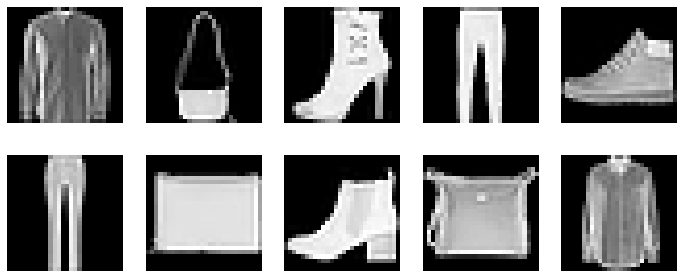

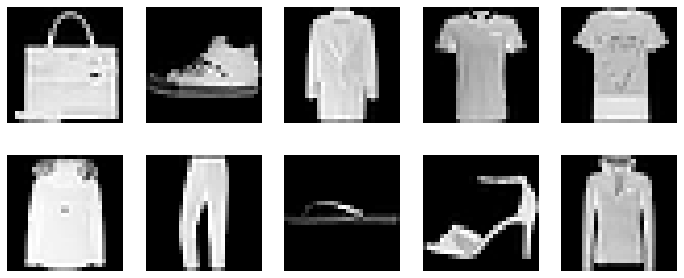

In [3]:
def plot_sample_images(data, dim=28):
    rand_idx = np.random.randint(0,data.shape[0], 10)

    fig, ax = plt.subplots(2, 5, figsize=(12, 5))
    ax = np.ravel(ax)
    for idx, rand in enumerate(rand_idx):
        ax[idx].imshow(data[rand].reshape(dim, dim), cmap='gray')
        ax[idx].axis('off')
    plt.show()

plot_sample_images(X_train)
plot_sample_images(X_test)

#### Preprocessing
- make image matrix shape compatible with model
- normalize image pixel intensities into smaller values to get small weight updates (less likely to overshooting optimal weights)

In [4]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

X_train = X_train / 255.0
X_test = X_test / 255.0

#### Train Test Split
- split data for traning and evaluation

In [5]:
random_state = 42

X_full = np.concatenate([X_train, X_test], axis=0)
y_full = np.concatenate([y_train, y_test], axis=0)

train_X, test_X, train_y, test_y = train_test_split(X_full, y_full, test_size=0.05, stratify=y_full, random_state=random_state)

print('shape of full input data: {}'.format(X_full.shape))
print('shape of train input data: {}'.format(train_X.shape))
print('shape of test input data: {}'.format(test_X.shape))

shape of full input data: (70000, 28, 28, 1)
shape of train input data: (66500, 28, 28, 1)
shape of test input data: (3500, 28, 28, 1)


#### Model Building

- VAE is used to generate data (image in this case) from random values given
- the random values are drawn from latent space (reduced space) distribution
- the goal is to generate meaningful data from random values
- also, values that are close in reduced space should lead to generating similar data in original space

- during training in order to generate image, values are sampled from distribution of latent space learned
- thus, VAE needs a sampling layer to pick random numbers from latent space distribution
- the sampling layer should make it possible for the network to backpropagate to encoder

In [6]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        shape = K.shape(z_mean)
        batch = shape[0]
        dim = shape[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0) 
        # reparameterization trick
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

- VAE loss is composed of 2 parts namely reconstruction loss and kullback leibler divergence
- 2 types of losses will be tried as reconstruction loss which measure difference between actual and generated image namely
    - mean squared error
    - binary cross entropy
- kullback leibler divergence is used for regularization to satisfy the goals of VAE stated above
- here kullback leibler divergence is used to regularize mean and variance learnt to not be far from mean and variance of standard normal distribution making the model not encode data far apart in the latent space 
- regularization is likely to make us get meaningful data produced using values sampled from standard normal distribution
- originally, kullback leibler divergence is used to measure distance between probability distributions

In [7]:
def build_mse_vae(optimizer, latent_dim=2):
    encoder_inputs = Input(shape=train_X.shape[1:])
    x = Conv2D(32, 2, activation='relu', strides=2, name='conv1')(encoder_inputs)
    x = Conv2D(64, 2, activation='relu', strides=2, name='conv2')(x)
    flattened = Flatten()(x)
    z_mean = Dense(latent_dim, name='mean')(flattened)
    z_log_var = Dense(latent_dim, name='log_var')(flattened)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = Model(encoder_inputs, z, name='encoder')
    encoder.summary()
    
    decoder_inputs =  Input(shape=(latent_dim,)) 
    x = Dense(3136)(decoder_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(32, 2, activation='relu', strides=2, name='convT1')(x)
    decoder_output = Conv2DTranspose(1, 2, activation='relu', strides=2, name='convT2')(x)

    decoder = Model(decoder_inputs, decoder_output, name='decoder')
    decoder.summary()
    
    output = decoder(encoder(encoder_inputs))

    model = Model(encoder_inputs, output, name='model_mse_loss')
    
    # mse loss unaggregated over batch
    reconstruction_loss = K.sum(K.square(encoder_inputs - output), axis=(1,2))

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

    loss = K.mean(reconstruction_loss + kl_loss)
    model.add_loss(loss)
    model.compile(optimizer=optimizer)
    return model

In [8]:
model_mse = build_mse_vae('adam', 2)

2022-01-09 16:33:02.188665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 16:33:02.282597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 16:33:02.283341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 16:33:02.284774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 32)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 7, 7, 64)     8256        conv1[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2[0][0]                      
____________________________________________________________________________________________

In [9]:
def build_bent_vae(optimizer, latent_dim=2):
    encoder_inputs = Input(shape=train_X.shape[1:])
    x = Conv2D(32, 2, activation='relu', strides=2, name='conv1')(encoder_inputs)
    x = Conv2D(64, 2, activation='relu', strides=2, name='conv2')(x)
    flattened = Flatten()(x)
    z_mean = Dense(latent_dim, name='mean')(flattened)
    z_log_var = Dense(latent_dim, name='log_var')(flattened)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = Model(encoder_inputs, z, name='encoder')
    encoder.summary()
    
    decoder_inputs =  Input(shape=(latent_dim,)) 
    x = Dense(3136)(decoder_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(32, 2, activation='relu', strides=2, name='convT1')(x)
    decoder_output = Conv2DTranspose(1, 2, activation='sigmoid', strides=2, name='convT2')(x)

    decoder = Model(decoder_inputs, decoder_output, name='decoder')
    decoder.summary()
    
    output = decoder(encoder(encoder_inputs))

    model = Model(encoder_inputs, output, name='model_bent_loss')
    
    # binary cross entropy unaggregated over batch
    reconstruction_loss = encoder_inputs * K.log(output) + (1 - encoder_inputs) * K.log(1 - output)
    reconstruction_loss = -1 * K.sum(reconstruction_loss, axis=(1,2))
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

    loss =  K.mean(reconstruction_loss + kl_loss)
    model.add_loss(loss)
    model.compile(optimizer=optimizer)
    return model

In [10]:
model_bent = build_bent_vae('adam', 2)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 32)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 7, 7, 64)     8256        conv1[0][0]                      
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2[0][0]                      
____________________________________________________________________________________________

In [11]:
# helper function returning a bunch of useful callbacks for models
def get_callbacks(file_path):
    return [
        ReduceLROnPlateau(factor=0.3, patience=3, monitor='val_loss', mode='min'),
        ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True, mode='min'),
        EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')

    ]

#### Model Training

In [12]:
batch_size = 128
history_mse = model_mse.fit(train_X, train_X, batch_size=batch_size, epochs=50, validation_split=0.05, callbacks=get_callbacks('vae_mse.h5'))

2022-01-09 16:33:06.113283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-09 16:33:07.515539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


494/494 [==============================] - 10s 6ms/step - loss: 47.1067 - val_loss: 37.3083
Epoch 2/50
494/494 [==============================] - 3s 6ms/step - loss: 35.2147 - val_loss: 34.4678
Epoch 3/50
494/494 [==============================] - 3s 6ms/step - loss: 33.5612 - val_loss: 33.4626
Epoch 4/50
494/494 [==============================] - 3s 6ms/step - loss: 32.8745 - val_loss: 33.0448
Epoch 5/50
494/494 [==============================] - 3s 6ms/step - loss: 32.4711 - val_loss: 32.9313
Epoch 6/50
494/494 [==============================] - 3s 6ms/step - loss: 32.1790 - val_loss: 32.5088
Epoch 7/50
494/494 [==============================] - 3s 6ms/step - loss: 31.9418 - val_loss: 32.2118
Epoch 8/50
494/494 [==============================] - 3s 6ms/step - loss: 31.7301 - val_loss: 32.0607
Epoch 9/50
494/494 [==============================] - 3s 6ms/step - loss: 31.5723 - val_loss: 31.9020
Epoch 10/50
494/494 [==============================] - 3s 6ms/step - loss: 31.4266 - val_los

In [13]:
def plot_history(history):
    get_plot_data = lambda x: (range(1, len(x) + 1), x)
    plt.figure(figsize=(8, 5))
    plt.plot(*get_plot_data(history.history['loss']), label='loss')
    plt.plot(*get_plot_data(history.history['val_loss']), label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Model training visualization')
    plt.legend()
    plt.show()

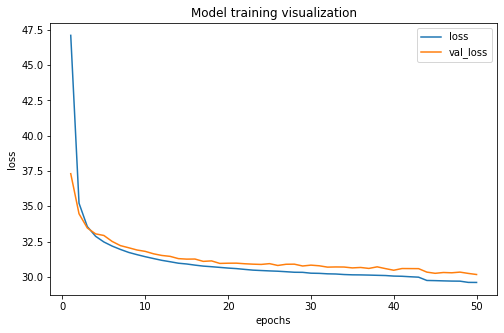

In [14]:
plot_history(history_mse)

- the total loss seems

In [15]:
history_bent = model_bent.fit(train_X, train_X, batch_size=batch_size, epochs=50, validation_split=0.05, callbacks=get_callbacks('vae_bent.h5'))

Epoch 1/50
494/494 [==============================] - 4s 6ms/step - loss: 329.5335 - val_loss: 293.4201
Epoch 2/50
494/494 [==============================] - 3s 6ms/step - loss: 288.1360 - val_loss: 285.5504
Epoch 3/50
494/494 [==============================] - 3s 6ms/step - loss: 282.3866 - val_loss: 281.0374
Epoch 4/50
494/494 [==============================] - 3s 6ms/step - loss: 278.8401 - val_loss: 278.0783
Epoch 5/50
494/494 [==============================] - 3s 6ms/step - loss: 276.5520 - val_loss: 276.2839
Epoch 6/50
494/494 [==============================] - 3s 6ms/step - loss: 275.0778 - val_loss: 275.3978
Epoch 7/50
494/494 [==============================] - 3s 6ms/step - loss: 273.9780 - val_loss: 274.1798
Epoch 8/50
494/494 [==============================] - 3s 6ms/step - loss: 273.1183 - val_loss: 273.6584
Epoch 9/50
494/494 [==============================] - 3s 7ms/step - loss: 272.4315 - val_loss: 272.8583
Epoch 10/50
494/494 [==============================] - 3s 7ms/st

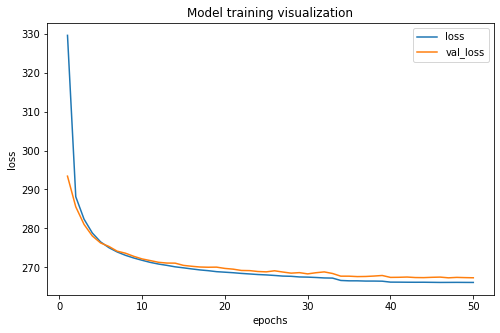

In [16]:
plot_history(history_bent)

#### Load Best Models

In [17]:
best_mse = load_model("./vae_mse.h5", custom_objects={'Sampling': Sampling})
best_bent = load_model("./vae_bent.h5", custom_objects={'Sampling': Sampling})

#### Prediction and Visualization

In [18]:
pred_mse = best_mse.predict(test_X)

pred_bent = best_bent.predict(test_X)

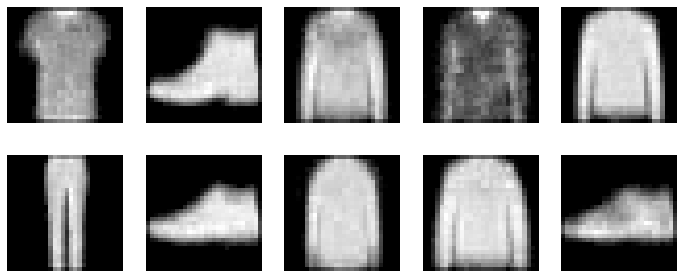

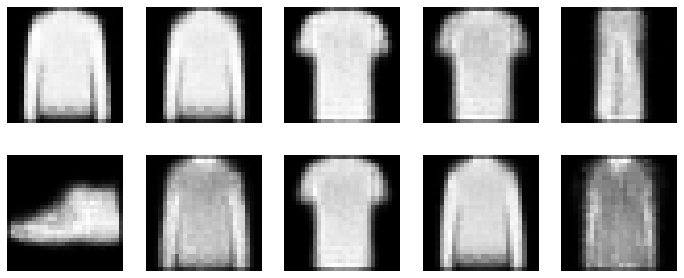

In [19]:
plot_sample_images(pred_mse)

plot_sample_images(pred_bent)

- one possible cons of binary cross-entropy is that, it is not suitable for non-binary target as in some cases it charges loss even though the actual and predicted target (pixel intensity) are identical

#### Final Model Building

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 32)   160         input_5[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 7, 7, 64)     8256        conv1[0][0]                      
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2[0][0]                      
____________________________________________________________________________________________

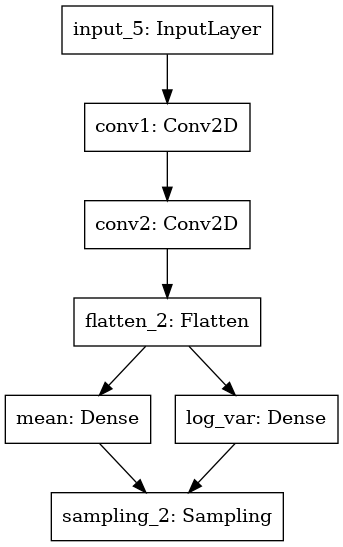

In [20]:
latent_dim = 2

encoder_inputs = Input(shape=train_X.shape[1:])
x = Conv2D(32, 2, activation='relu', strides=2, name='conv1')(encoder_inputs)
x = Conv2D(64, 2, activation='relu', strides=2, name='conv2')(x)
flattened = Flatten()(x)
z_mean = Dense(latent_dim, name='mean')(flattened)
z_log_var = Dense(latent_dim, name='log_var')(flattened)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, z, name='encoder')

encoder.summary()
plot_model(encoder, 'encoder_model.png')

- first the encoder downsamples image using convolutional layers
- then, the reduced image is used to learn parameters i.e. mean and log variance of latent space
- lastly, values are randomly sampled from latent space distribution using the parameters learned

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
convT1 (Conv2DTranspose)     (None, 14, 14, 32)        8224      
_________________________________________________________________
convT2 (Conv2DTranspose)     (None, 28, 28, 1)         129       
Total params: 17,761
Trainable params: 17,761
Non-trainable params: 0
_________________________________________________________________


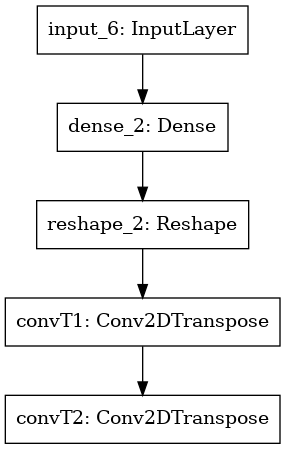

In [21]:
decoder_inputs =  Input(shape=(latent_dim,)) 
x = Dense(3136)(decoder_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(32, 2, activation='relu', strides=2, name='convT1')(x)
decoder_output = Conv2DTranspose(1, 2, activation='relu', strides=2, name='convT2')(x)

decoder = Model(decoder_inputs, decoder_output, name='decoder')

decoder.summary()
plot_model(decoder, 'decoder_model.png')

- for the decoder, it receives sampled values from encoder and map them to larger number of features
- then, the features are reshaped into 2D matrix to further upsample and generate image

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 20964     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         17761     
Total params: 38,725
Trainable params: 38,725
Non-trainable params: 0
_________________________________________________________________


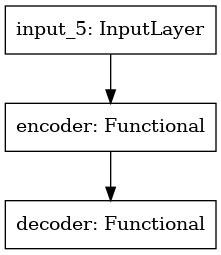

In [22]:
output = decoder(encoder(encoder_inputs))

model = Model(encoder_inputs, output)
model.summary()
plot_model(model)

- the main model simply pass input image to encoder
- the output from encoder is passed to decoder resulting in image construction

In [23]:
reconstruction_loss = K.sum(K.square(encoder_inputs - output), axis=(1,2))
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='adam')

In [24]:
history = model.fit(train_X, train_X, batch_size=batch_size, epochs=50, validation_split=0.05, callbacks=get_callbacks('vae.h5'))

Epoch 1/50
494/494 [==============================] - 4s 6ms/step - loss: 47.1564 - val_loss: 37.7148
Epoch 2/50
494/494 [==============================] - 3s 6ms/step - loss: 35.1963 - val_loss: 34.4520
Epoch 3/50
494/494 [==============================] - 3s 6ms/step - loss: 33.4850 - val_loss: 33.5284
Epoch 4/50
494/494 [==============================] - 3s 6ms/step - loss: 32.8168 - val_loss: 32.9836
Epoch 5/50
494/494 [==============================] - 3s 6ms/step - loss: 32.4056 - val_loss: 32.5682
Epoch 6/50
494/494 [==============================] - 3s 6ms/step - loss: 32.1019 - val_loss: 32.2880
Epoch 7/50
494/494 [==============================] - 3s 6ms/step - loss: 31.8774 - val_loss: 32.1668
Epoch 8/50
494/494 [==============================] - 3s 6ms/step - loss: 31.7171 - val_loss: 32.0298
Epoch 9/50
494/494 [==============================] - 3s 6ms/step - loss: 31.5851 - val_loss: 32.0000
Epoch 10/50
494/494 [==============================] - 3s 7ms/step - loss: 31.4385

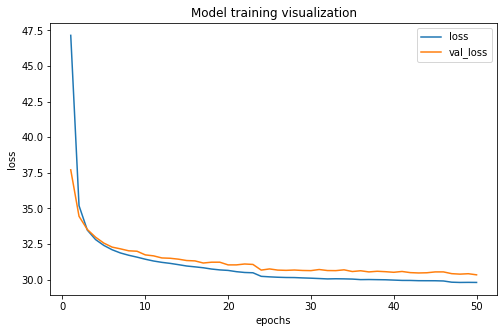

In [25]:
plot_history(history)

In [26]:
def plot_latent_space(grid_x, grid_y, decoder, figsize=15):
    assert grid_x.shape[0] == grid_y.shape[0]
    n = grid_x.shape[0]
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.sort(grid_x)
    grid_y = np.sort(grid_y)
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()

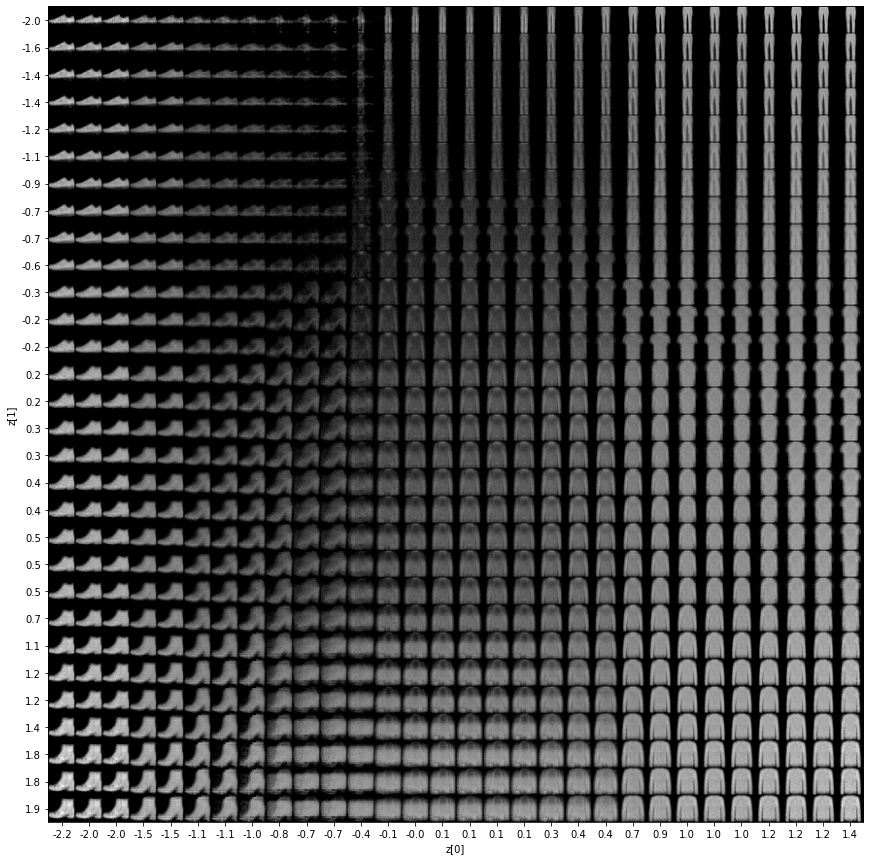

In [27]:
grid_x, grid_y = np.random.normal(0, 1, 30), np.random.normal(0, 1, 30)
plot_latent_space(grid_x, grid_y, decoder)

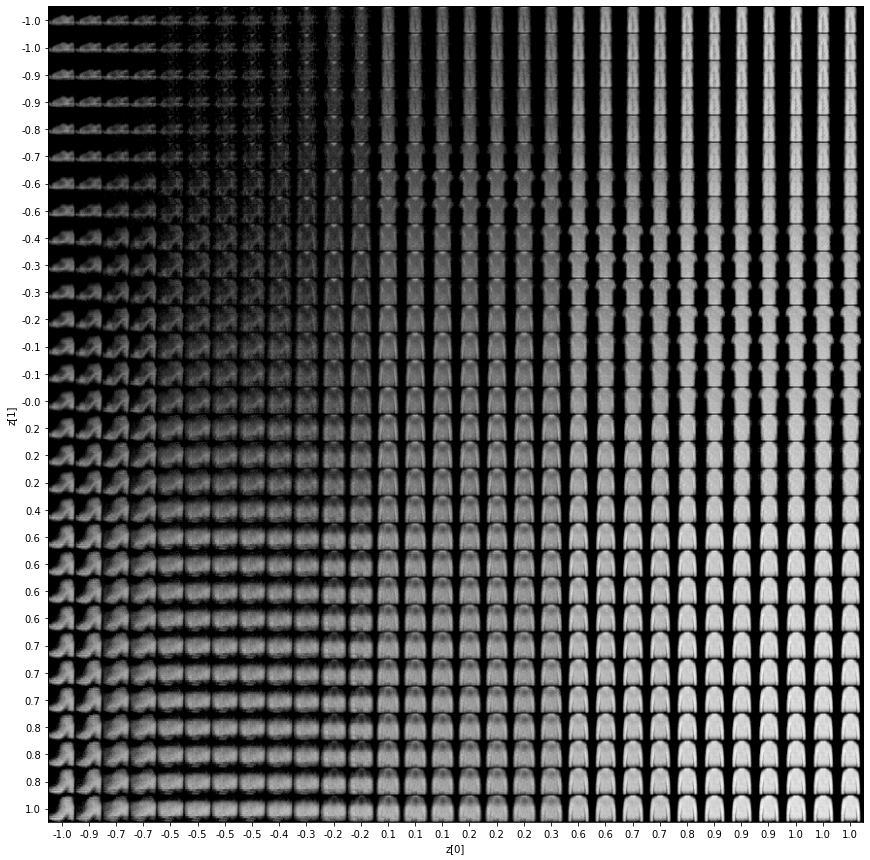

In [28]:
grid_x, grid_y = np.random.uniform(-1, 1, 30), np.random.uniform(-1, 1, 30)
plot_latent_space(grid_x, grid_y, decoder)

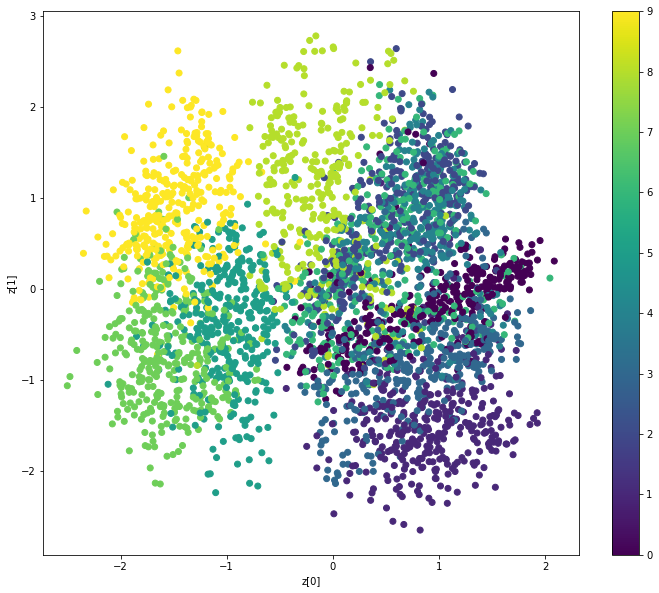

In [29]:
def plot_label_clusters(encoder, data, labels):
    z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, test_X, test_y)

- from the plots, points that are close in latent space seems to produce similar images
- sampling values from ther distributions like uniform distribution led to generation of ununderstandable images